### Data Exploration


a) Let's start by loading the data and checking how it looks like


In [2]:
import pandas as pd

In [3]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")

In [4]:
def check_missing_values(df: pd.DataFrame, df_name: str) -> None:
    if df.isnull().values.any():
        print(f"There are some missing values in {df_name} dataframe.")
    else:
        print(f"There aren't any missing values in {df_name} dataframe")


def check_types(df: pd.DataFrame, df_name: str) -> None:
    filtered = df.select_dtypes(exclude=["float64"])
    print(
        f"Columns of {df_name} dataframe with non-float type: {list(filtered.columns)}"
    )

In [5]:
X_train.info()

print()
check_types(X_train, "X_train")
print()
check_missing_values(X_train, "X_train")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9000 entries, LINC01409 to AC007325.4
dtypes: float64(9000)
memory usage: 260.5 MB

Columns of X_train dataframe with non-float type: []

There aren't any missing values in X_train dataframe


In [6]:
y_train.info()

print()
check_types(y_train, "y_train")
print()
check_missing_values(y_train, "y_train")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB

Columns of y_train dataframe with non-float type: ['Id']

There aren't any missing values in y_train dataframe


In [7]:
X_test.info()

print()
check_types(X_test, "X_test")
print()
check_missing_values(X_test, "X_test")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9000 entries, LINC01409 to AC007325.4
dtypes: float64(9000)
memory usage: 46.0 MB

Columns of X_test dataframe with non-float type: []

There aren't any missing values in X_test dataframe


#### We can notice that:

- There are 9000 independent variables in both train and test X dataframes
- There are 3794 observations in the training set (both X and y), and 670 observations in the test set
- All relevant variables have float type, there's no need to convert them. Only `Id` in the y_train dataframe has int type, but as it's just an identifier of the observation, we don't need to worry about it
- There is no missing data in any dataframe


b) Now let's investigate the empirical distribution of the response variable, we'll do it in two steps:

1. Calculate some basic statistics
2. Present a histogram + density estimator plot


In [8]:
stats = y_train["Expected"].describe()
print(stats)

count    3794.000000
mean        0.791096
std         0.860856
min         0.000000
25%         0.000000
50%         0.311748
75%         1.662514
max         2.860416
Name: Expected, dtype: float64


In [9]:
print(f"CV coefficient: {stats["std"] / stats["mean"]:.4f}")

CV coefficient: 1.0882


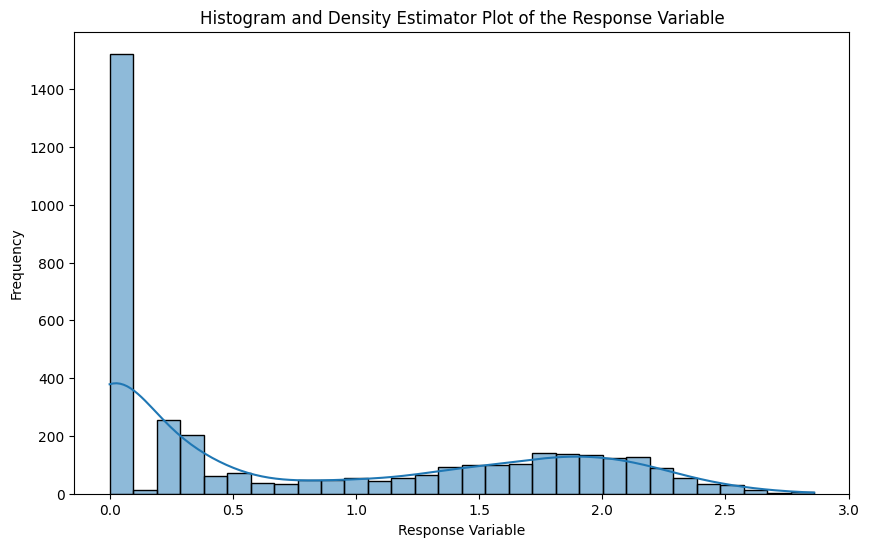

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_train["Expected"], kde=True, bins=30)
plt.title("Histogram and Density Estimator Plot of the Response Variable")
plt.xlabel("Response Variable")
plt.ylabel("Frequency")
plt.show()

In [11]:
print(
    f"Fraction of observations with response variable equal to 0: {(y_train["Expected"] == 0).sum() / y_train["Expected"].count():.4f}"
)

Fraction of observations with response variable equal to 0: 0.4014


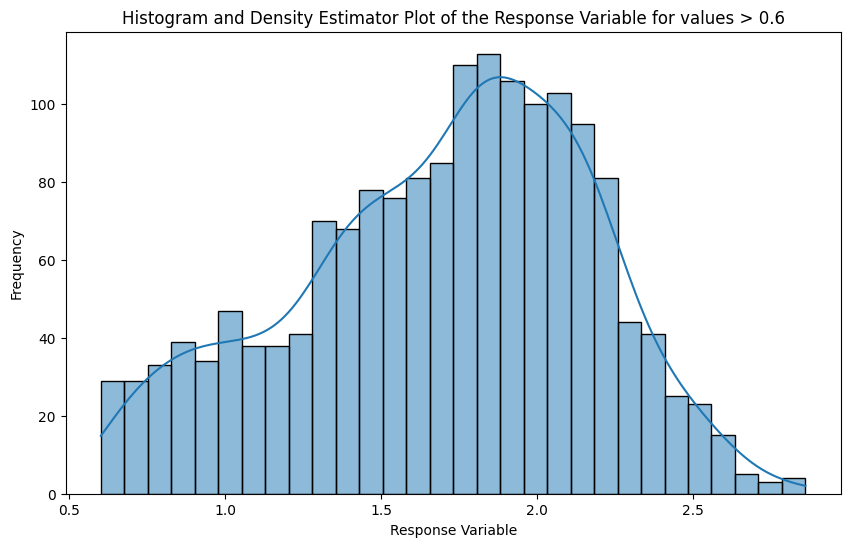

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train["Expected"][y_train["Expected"] > 0.6], kde=True, bins=30)
plt.title(
    "Histogram and Density Estimator Plot of the Response Variable for values > 0.6"
)
plt.xlabel("Response Variable")
plt.ylabel("Frequency")
plt.show()

#### Key notes:

- Values range from 0 to around 2.86
- Mean value is much higher than the median value, which suggests that the distribution is heavily right-skewed (which is also confirmed by the above histogram)
- CV coefficient equal to around 1.0882 can be considered as a high variability of data, as the standard deviation is higher than the mean value
- There's a huge part of observations for which the response variable is equal to 0, it's around 40%
- If we take a look only at values > 0.6, we can see they're more normally distributed (however we can't say it's a perfect normal distribution)


c) Finally let's analyze the correlation coefficients, looking for potentially significant variables and multicolinearity amongst them


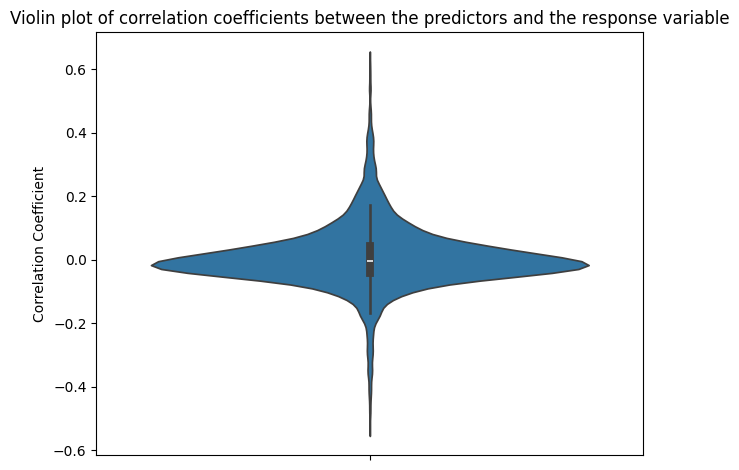

In [13]:
correlations = X_train.corrwith(y_train["Expected"])

sns.violinplot(correlations)
plt.title(
    f"Violin plot of correlation coefficients between the predictors and the response variable"
)
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

The result we got is quite predictable - amongst all the 9000 variables only a small part of them is potentially significant. The correlation coefficient for majority of them is around 0, which suggests no significant association.


Let's now search for multicolinearity amongst the most correlated variables:


FCN1        0.623565
VCAN        0.618140
S100A9      0.598952
CD36        0.597179
FTH1        0.581045
              ...   
TMEM176B    0.376995
PLAUR       0.376783
GNLY        0.376133
CD3G        0.375530
TGFBI       0.374922
Length: 100, dtype: float64


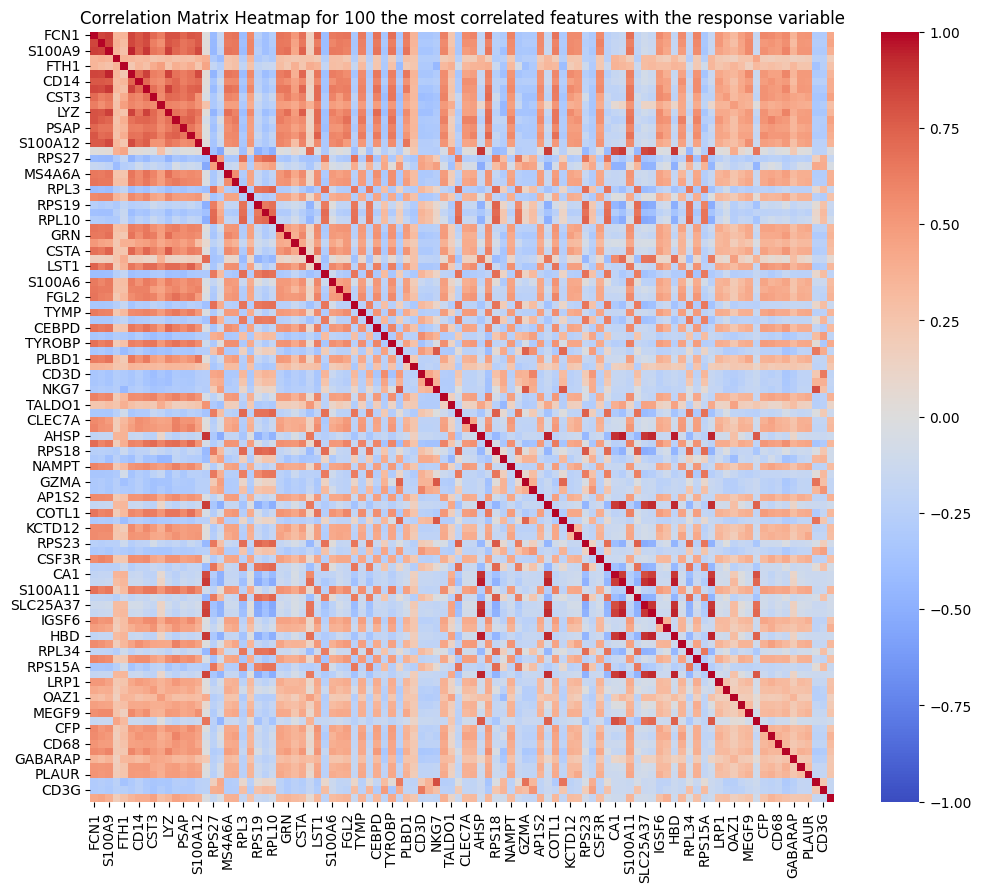

In [14]:
sorted_correlations = correlations.abs().sort_values(ascending=False)
top_correlations = sorted_correlations.head(100)
print(top_correlations)

X_train_filtered = X_train[top_correlations.index]

plt.figure(figsize=(12, 10))
sns.heatmap(X_train_filtered.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title(
    "Correlation Matrix Heatmap for 100 the most correlated features with the response variable"
)
plt.show()

#### Observations:

- There are some highly correlated features, especially amongst the top 16 (with regard to the correlation with response variable) ones
- There are also some noticeable positive correlations for single pairs in the bottom part of the heatmap, e.g. for the `CA1` variable
- For the same variables as in the previous observation, we can spot some higher (in terms of absolute value) negative correlation values, although these aren't as high and as numerous as the positive ones
- In general there's some multicolinearity between the features, which we will need to take into consideration in the further parts of this project


### ElasticNet


ElasticNet is a linear regression model that combines the properties of both Ridge and Lasso regression, and therefore aims to improve the limitations of both by balancing their penalties. Model estimates the linear coefficients/weights, denoted by $\beta$. The estimator can be defined as:

$$ \hat{\beta} = \text{argmin}_{\beta}(\|y - X\beta\|^2_2 + \lambda_{2} \|\beta\|^2_2 + \lambda_1\|\beta\|_1)$$
where:\
$y$ - vector of response variable\
$X$ - matrix of dependent variables\
$\lambda_{2}$ - Ridge coefficient\
$\lambda_{1}$ - LASSO coefficient

Considering the above and the sklearn documentation, the optimization function can be written as:

$$ L(\beta) = \frac{1}{2n} \|y - X\beta\|^2_2 + \alpha \cdot \text{l1\_ratio} \cdot \|\beta\|_1 + \frac{1}{2} \alpha \cdot (1 - \text{l1\_ratio}) \cdot ||\beta||^2_2 $$
where:\
$n$ - number of observations\
$\alpha$ - hyperparameter controlling the overall strength of the regularization, when equal to 0 the model effectively becomes the OLS\
l1_ratio - hyperparameter balancing the LASSO and Ridge penalties, when equal to 0 the model reduces to the Ridge regression, and for value equal to 1 it reduces to the LASSO regression

In [25]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

np.random.seed(42)

hyperparameters_to_test = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3],
    "l1_ratio": [
        0.1,
        0.5,
        0.7,
        0.9,
        0.95,
        0.99,
        1,
    ],  # testing more values near 1 as suggested by the sklearn documentation
}

elastic_net = ElasticNet()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=hyperparameters_to_test,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

X = X_train
y = y_train["Expected"]

grid_search_en.fit(X, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.944e+00, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.288) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.289) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.296) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.580e+00, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.297) total time= 1.2min
[CV 2/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.275) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.922e+00, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.273) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.604e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+00, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.299) total time= 1.2min
[CV 2/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.331) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+00, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+00, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.321) total time= 1.2min
[CV 1/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.315) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.321) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+00, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.324) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.268) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.289) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

[CV 2/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.270) total time= 1.1min
[CV 5/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.281) total time= 1.2min
[CV 5/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.275) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.288) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.260) total time= 1.2min
[CV 2/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.268) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.275) total time= 1.1min
[CV 1/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.289) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.277) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.258) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.288) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.272) total time= 1.1min
[CV 5/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.273) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

[CV 1/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.287) total time= 1.1min
[CV 5/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.272) total time= 1.1min
[CV 3/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.257) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.267) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.272) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.273) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.267) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.250) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.256) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.859e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.175) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.501e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.015, test=-0.180) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.433e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.170) total time= 1.1min
[CV 4/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.164) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.002, test=-0.232) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.248) total time= 1.2min
[CV 1/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.023, test=-0.164) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.241) total time= 1.2min
[CV 5/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.169) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.025, test=-0.153) total time= 1.1min
[CV 5/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.002, test=-0.243) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.024, test=-0.154) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.024, test=-0.145) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.033, test=-0.141) total time= 1.1min
[CV 2/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.034, test=-0.143) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.032, test=-0.131) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.025, test=-0.152) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.032, test=-0.145) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.031, test=-0.152) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.033, test=-0.149) total time= 1.1min
[CV 3/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.033, test=-0.143) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.363e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.034, test=-0.129) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.413e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.035, test=-0.141) total time= 1.2min
[CV 5/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.035, test=-0.139) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.034, test=-0.148) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.036, test=-0.140) total time= 1.1min
[CV 2/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.035, test=-0.141) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.036, test=-0.138) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.036, test=-0.126) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.035, test=-0.147) total time= 1.1min
[CV 4/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.035, test=-0.127) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.037, test=-0.140) total time= 1.1min
[CV 2/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.036, test=-0.141) total time= 1.2min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.712e+00, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.037, test=-0.137) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.039, test=-0.138) total time= 1.1min


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.040, test=-0.134) total time= 1.2min
[CV 2/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.107, test=-0.117) total time=  15.3s
[CV 1/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.108, test=-0.118) total time=  19.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.100, test=-0.125) total time=  19.9s
[CV 2/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.099, test=-0.116) total time=  25.1s
[CV 3/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.100, test=-0.116) total time=  25.1s
[CV 1/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.098, test=-0.116) total time=  28.1s
[CV 4/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.103, test=-0.107) total time=  26.1s
[CV 3/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.108, test=-0.118) total time=  18.8s
[CV 4/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.111, test=-0.110) total time=  20.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.9;, score=(train=-0.113, test=-0.1

/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.041, test=-0.134) total time= 1.2min
[CV 5/5] END alpha=0.01, l1_ratio=0.99;, score=(train=-0.113, test=-0.134) total time=  18.3s
[CV 2/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.115, test=-0.120) total time=  13.9s
[CV 3/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.115, test=-0.121) total time=  13.8s
[CV 1/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.162, test=-0.162) total time=   5.7s
[CV 4/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.118, test=-0.114) total time=  15.2s


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.040, test=-0.119) total time= 1.2min
[CV 5/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.041, test=-0.131) total time= 1.2min
[CV 2/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.117, test=-0.121) total time=  12.5s
[CV 2/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.162, test=-0.161) total time=   5.2s
[CV 3/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.163, test=-0.162) total time=   5.2s
[CV 1/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.117, test=-0.123) total time=  16.3s
[CV 5/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.115, test=-0.133) total time=  12.7s
[CV 4/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.163, test=-0.158) total time=   6.2s
[CV 1/5] END alpha=0.1, l1_ratio=0.7;, score=(train=-0.175, test=-0.174) total time=   4.9s
[CV 4/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.119, test=-0.115) total time=  14.7s
[CV 4/5] END alpha=0.1, l1_ratio=0.7;, score=(train=-0.176, test=-0.171) total

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 100.0, 1000.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [26]:
print(f"Hyperparameters of the best model obtained: {grid_search_en.best_params_}")

cv_results_en = grid_search_en.cv_results_
best_index_en = grid_search_en.best_index_

train_err_en = -cv_results_en["mean_train_score"][best_index_en]
val_err_en = -cv_results_en["mean_test_score"][best_index_en]

print(f"Mean train error of the best model obtained: {train_err_en}")
print(f"Mean validation error of the best model obtained: {val_err_en}")

Hyperparameters of the best model obtained: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean train error of the best model obtained: 0.10011185944375278
Mean validation error of the best model obtained: 0.1162091941485709


Grid search was performed for various values of hyperparameters `alpha` and `l1_ratio`.

`alpha` was tested for different orders of magnitude, i.e. from 1e-4 to 1e3

`l1_ratio` was tested in range [0, 1], with more emphasis on the values closer to 1 (as suggested by the sklearn documentation [here](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.ElasticNetCV.html))

The `KFold` object was declared separately from the `GridSearchCV` in order to be reused later, assuring the reasonable comparison of ElasticNet and RandomForest models. The cross-validation was performed using 5 folds, i.e. the validation set size is 20% of the whole dataset size (~759 observations), which should be enough for our case. It's a little more than the size of the test set, which is 670. Using more folds might be beneficial (as there would be more data for training), but it would reduce size of the validation set and could therefore provide less meaningful results.

### Random Forest

Now let's try a different, tree-based approach. We'll feet a `RandomForestRegressor` using the same cross-validation + grid search approach, but this time tuning different hyperparameters. As the mentioned model has many such parameters and we only want to tune 3 of them, I decided to choose those considered in the literature as impactful ones, i.e.:
- `n_estimators` - numbers of trees in the forest
- `max_features` - number of features to consider when looking for the best split
- `min_samples_split` - minimum number of samples required to split an internal node

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


hyperparameters_to_test = {
    "n_estimators": [10, 20, 50, 100],
    "max_features": ["sqrt", 0.1, 0.25, 0.5],
    "min_samples_split": [2, 5, 8, 11]
}

random_forest = RandomForestRegressor()

grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=hyperparameters_to_test,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

grid_search_rf.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.027, test=-0.152) total time=   1.6s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.029, test=-0.144) total time=   1.6s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.029, test=-0.156) total time=   1.4s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.030, test=-0.147) total time=   1.8s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.031, test=-0.152) total time=   1.4s
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;, score=(train=-0.022, test=-0.141) total time=   2.7s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;, score=(train=-0.022, test=-0.143) total time=   2.9s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;,

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.1, 0.25, 0.5],
                         'min_samples_split': [2, 5, 8, 11],
                         'n_estimators': [10, 20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [32]:
print(f"Hyperparameters of the best model obtained: {grid_search_rf.best_params_}")

cv_results_rf = grid_search_rf.cv_results_
best_index_rf = grid_search_rf.best_index_

train_err_rf = -cv_results_rf["mean_train_score"][best_index_rf]
val_err_rf = -cv_results_rf["mean_test_score"][best_index_rf]

print(f"Mean train error of the best model obtained: {train_err_rf}")
print(f"Mean validation error of the best model obtained: {val_err_rf}")

Hyperparameters of the best model obtained: {'max_features': 0.25, 'min_samples_split': 5, 'n_estimators': 100}
Mean train error of the best model obtained: 0.01733825321037618
Mean validation error of the best model obtained: 0.10361304718329842


Now let's summarize the above results in a tabular form. For the reference let's use a simple model, which assigns the arithmetic mean of the dependent variable to any independent variable values.

In [42]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_validate


class ReferenceRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, mean):
        super().__init__()

        self.mean = mean

    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.full(X.shape[0], self.mean)


reference_model = ReferenceRegressor(y.mean())

cv_results_ref = cross_validate(
    reference_model,
    X,
    y,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

train_err_ref = -cv_results_ref["train_score"].mean()
val_err_ref = -cv_results_ref["test_score"].mean()

print()
print(f"Mean train error of the best model obtained: {train_err_ref}")
print(f"Mean validation error of the best model obtained: {val_err_ref}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] END ................., score=(train=-0.731, test=-0.779) total time=   0.1s
[CV] END ................., score=(train=-0.748, test=-0.713) total time=   0.1s
[CV] END ................., score=(train=-0.740, test=-0.743) total time=   0.2s
[CV] END ................., score=(train=-0.746, test=-0.720) total time=   0.2s
[CV] END ................., score=(train=-0.739, test=-0.750) total time=   0.2s

Mean train error of the best model obtained: 0.7408770638799047
Mean validation error of the best model obtained: 0.7408793416328249


In [45]:
results = pd.DataFrame(
    index=["ElasticNet", "Random Forest", "Reference Model"],
    columns=["Train Error", "Validation Error"],
)

results["Train Error"] = [train_err_en, train_err_rf, train_err_ref]
results["Validation Error"] = [val_err_en, val_err_rf, val_err_ref]

results

,Train Error,Validation Error
ElasticNet,0.100112,0.116209
Random Forest,0.017338,0.103613
Reference Model,0.740877,0.740879


Obviously both tested models work much better than the simple reference model.

We can observe significantly lower validation error for the Random Forest than for the ElasticNet, not to mention the train error, where the difference is huge. It's a predictable result, as the Random Forest model is more sophisticated than the ElasticNet and we dedicated (as we needed to) more compute time to the grid search in its case.

To answer the question "Which model is the best?" we need to ask ourselves what are our priorities. If it's a predictive power, then we should go for the Random Forest. However if we've got a restricted budget and/or resources, it may be a better idea to train the ElasticNet as the results are also great and it's a less resource-heavy model.